In [1]:
import numpy as np
import pandas as pd

from scipy import spatial

from matplotlib import pyplot as plt

import geopandas as gpd
import shapely as shp

In [2]:
# Dirección de los datos.
#path = "../Material/Clases/Examen 1/"

# Nombre del archivo de curvas.
#curvas_n = "cni250kgw"

# Cargamos las curvas de nivel por segmentos.
#curvas_sep = gpd.read_file(path + curvas_n + ".shp")

#curvas_sep.head()

In [3]:
# Unimos los segmentos de las curvas de nivel.

#i = curvas_sep["COV_ID"].unique()[0]
#level = curvas_sep[ curvas_sep["COV_ID"] == i ]
#curvas = level.iloc[[0]].copy()
#curvas["geometry"] = shp.ops.linemerge(level["geometry"].to_numpy())
#curvas = curvas.drop("COV_", axis = 1)

#for i in curvas_sep["COV_ID"].unique()[1:]:
#    level = curvas_sep[ curvas_sep["COV_ID"] == i ]

#    linea = level.iloc[[0]].copy()
#    linea["geometry"] = shp.ops.linemerge(level["geometry"].to_numpy())
#    linea = linea.drop("COV_", axis = 1)

#    curvas = pd.concat([curvas, linea])

#curvas = curvas[ ~ curvas["geometry"].is_empty ].reset_index(drop = True)
#curvas.to_csv(path + curvas_n + ".csv")

#curvas


In [4]:
# Dirección de los datos.
path = "../Material/Clases/Examen 1/"

# Nombre del archivo de curvas.
curvas_n = "cni250kgw"

# Cargamos las curvas de nivel.
curvas = pd.read_csv(path + curvas_n + ".csv")
curvas["geometry"] = curvas["geometry"].apply(shp.wkt.loads)
curvas = gpd.GeoDataFrame(curvas, geometry = "geometry" )
# Las coordenadas están en WGS84 EPSG:4326.
curvas = curvas.set_crs(4326)

curvas

,Unnamed: 0,LENGTH,COV_ID,CONTOUR,geometry
0,0,0.034437,216,401,"LINESTRING (-116.82642 32.54493, -116.82298 32..."
1,1,0.011955,218,1201,"LINESTRING (-116.06445 32.60602, -116.06354 32..."
2,2,0.037524,222,401,"LINESTRING (-116.84456 32.53133, -116.84172 32..."
3,3,0.005956,224,201,"LINESTRING (-117.09906 32.50707, -117.09878 32..."
4,4,0.061949,226,601,"LINESTRING (-116.80413 32.52467, -116.80380 32..."
...,...,...,...,...,...
39936,39936,0.171456,7559,1,"LINESTRING (-111.85657 28.78637, -111.85340 28..."
39937,39937,0.012476,7678,601,"MULTILINESTRING ((-103.16578 28.97441, -103.16..."
39938,39938,0.062783,1385,1401,"LINESTRING (-107.96337 31.78505, -107.96291 31..."
39939,39939,0.253680,2030,1201,"LINESTRING (-110.81010 31.33491, -110.80983 31..."


In [5]:
# Cargamos las Subcuencas.

# Region hidrológica a usar.
RH = "RH01"

# Cargamos archivo.
subc = gpd.read_file(path + "subcuenca.shp")
# Las coordenadas están en WGS84 EPSG:4326.
subc = subc.to_crs(4326)
# Cramos una columna con la región hidrológica.
subc["CVE_RH"] = subc["CVE_SUBCUE"].apply(lambda x: x[0:4])

# Extraemos la subcuenca con la que trabajaremos.
Subcuenca = subc[ subc["CVE_SUBCUE"] == "RH01Bd" ].reset_index(drop = True)

Subcuenca

,CVE_SUBCUE,SUBCUENCA,TIPO,AREA,PERIMETRO,geometry,CVE_RH
0,RH01Bd,A. El Salado,EXORREICA,1853.28 kmÂ²,407.08 km,"POLYGON ((-115.54818 31.38141, -115.54826 31.3...",RH01


In [6]:
# Graficamos la subcuenca.
Subcuenca.explore()

In [7]:
# Curvas de nivel que caen dentro de la subcuenca.
curvas[ Subcuenca.loc[0, "CVE_SUBCUE"] ] = curvas.intersection(
    Subcuenca.loc[0, "geometry"] )
subc_c = curvas.set_geometry( Subcuenca.loc[0, "CVE_SUBCUE"] ).copy()

# Eliminamos las curvas de nivel que no cruzan la subcuenca.
subc_c = subc_c[ ~ subc_c.is_empty ]

# Escogemos solo las curvas de nivel que son múltiplos de 400 m.
subc_c = subc_c[ ( subc_c["CONTOUR"] - 1) % 400 == 0 
    ].sort_values("CONTOUR", ascending = False).reset_index(drop = True)

subc_c.head()

,Unnamed: 0,LENGTH,COV_ID,CONTOUR,geometry,RH01Bd
0,942,0.165202,2059,2401,"LINESTRING (-115.57628 30.99753, -115.57730 30...","MULTILINESTRING ((-115.49005 31.11477, -115.49..."
1,1123,0.176539,2272,2001,"LINESTRING (-115.57234 31.06006, -115.57602 31...","LINESTRING (-115.52470 31.16751, -115.52546 31..."
2,672,0.051059,1517,2001,"LINESTRING (-115.51960 31.22273, -115.51740 31...","LINESTRING (-115.53520 31.22925, -115.53456 31..."
3,370,0.078376,811,1601,"LINESTRING (-115.73342 31.65618, -115.73141 31...","MULTILINESTRING ((-115.73342 31.65618, -115.73..."
4,445,0.168852,966,1601,"LINESTRING (-115.60616 31.56713, -115.60595 31...","MULTILINESTRING ((-115.60616 31.56713, -115.60..."


In [8]:
# A coordenadas UTM 11N ESPSG:32611.
CRS = 32611
Subcuenca = Subcuenca.to_crs(CRS)
subc_c = subc_c.to_crs(CRS)
subc_c["geometry"] = subc_c["geometry"].to_crs(CRS)

# Agregamos el área.
Subcuenca["AREA"] = Subcuenca.area

subc_c.explore()

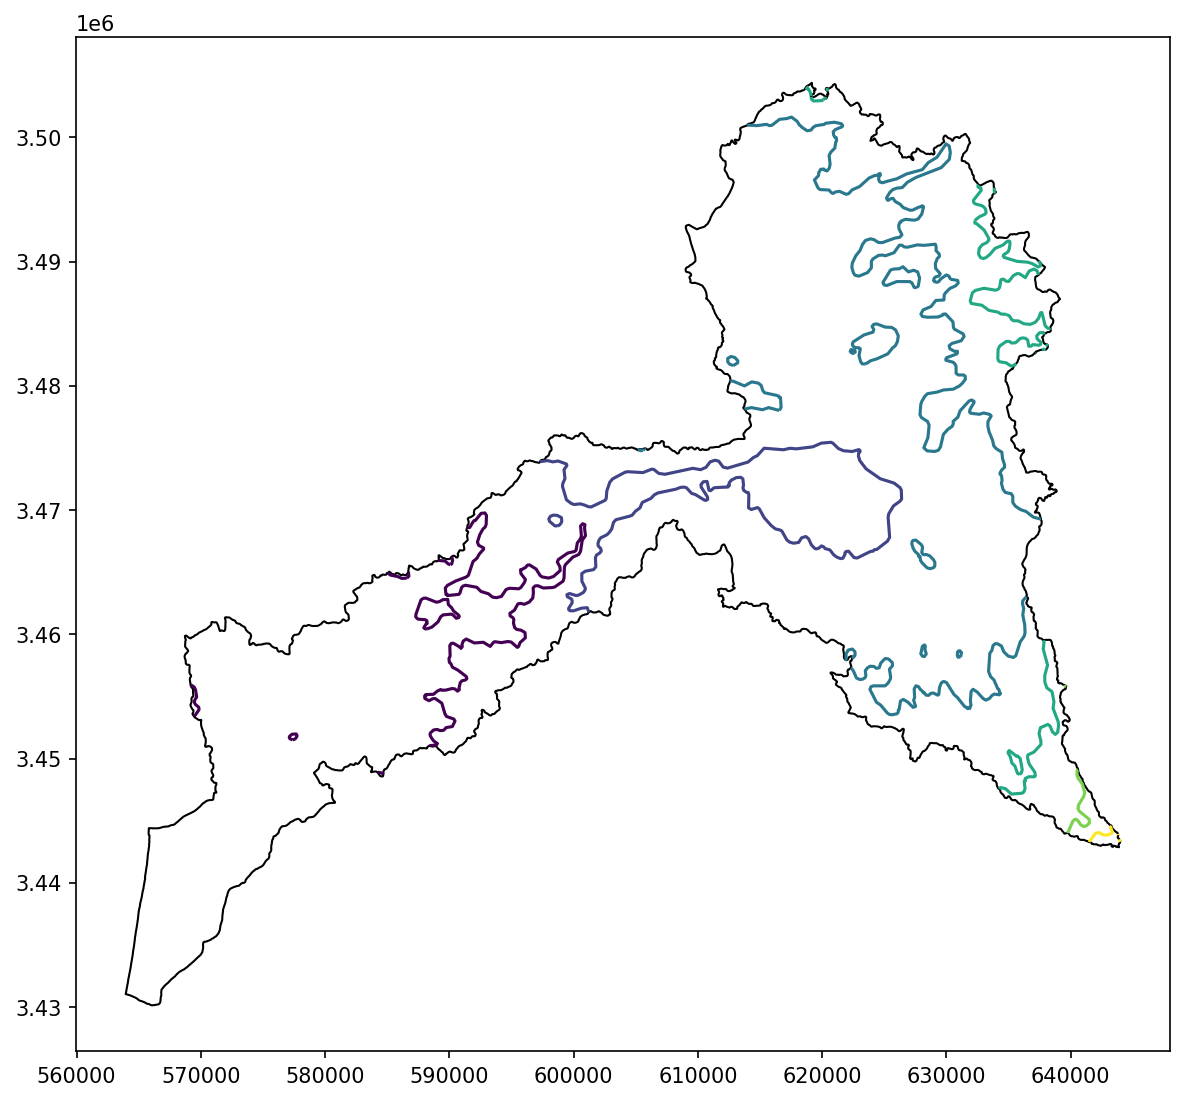

In [9]:
# Curvas de nivel que cruzan la subcuenca.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 8)
fig.set_dpi(150) 

# Graficamos la subcuenca.
Subcuenca.plot(ax = ax, color = "None", edgecolor = "k")
# Graficamos las curvas de nivel.
subc_c.plot("CONTOUR", ax = ax)
fig.tight_layout()
plt.show()

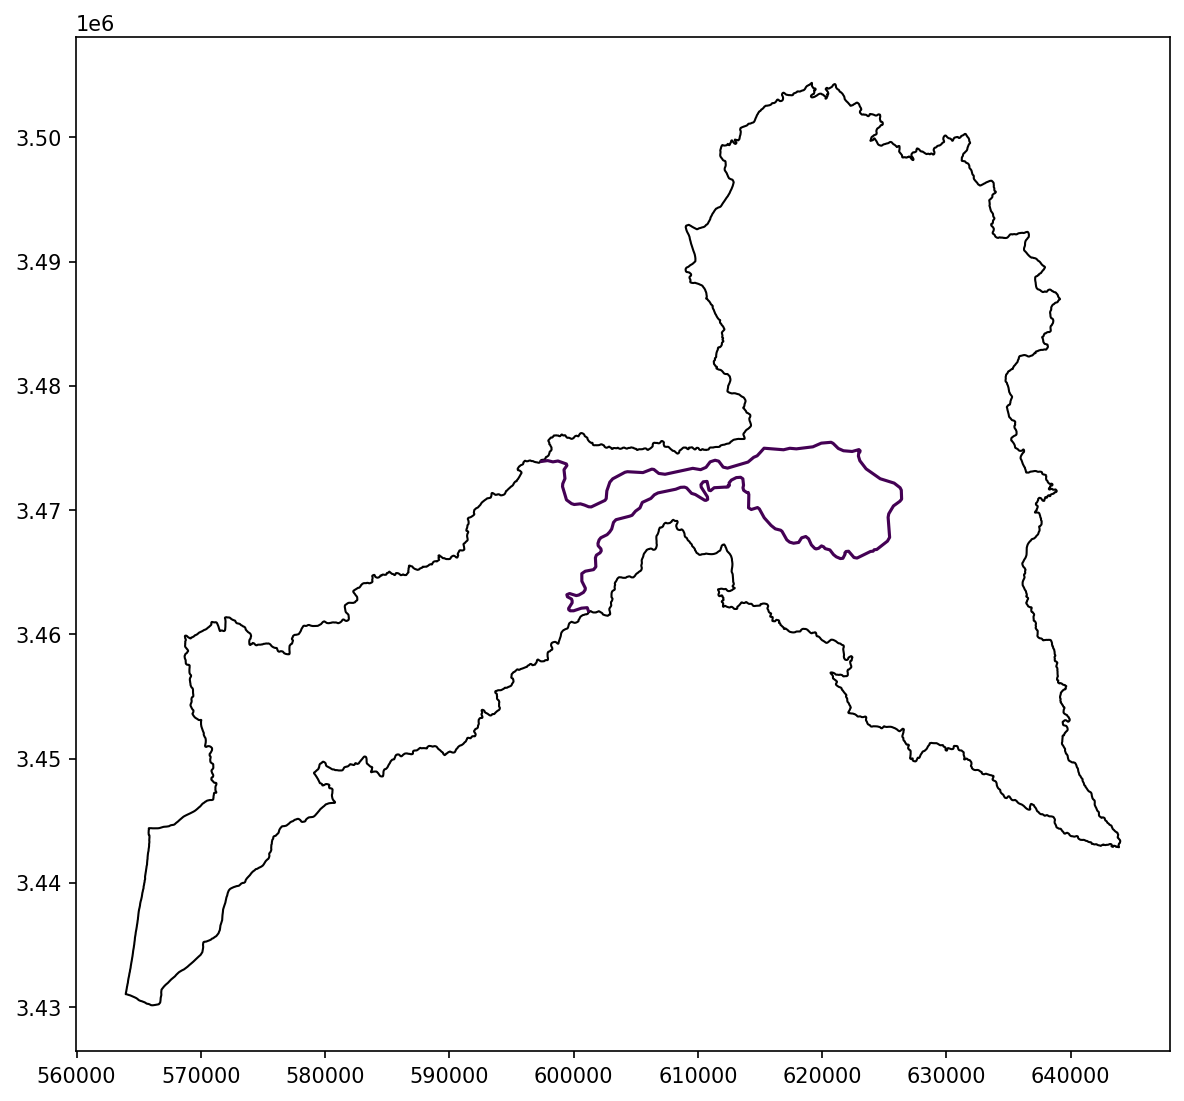

In [10]:
# Curvas de nivel individuales que cruzan la cuenca.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 8)
fig.set_dpi(150) 

i = 22

# Graficamos la subcuenca.
Subcuenca.plot(ax = ax, color = "None", edgecolor = "k")
# Graficamos las curvas de nivel individuales que cruzan la subcuenca.
subc_c.loc[[i]].plot("CONTOUR", ax = ax)
# Curvas de nivel individuales completas.
#subc_c.set_geometry("geometry").loc[[i]].plot("CONTOUR", ax = ax)

fig.tight_layout()
plt.show()

(30, 6)


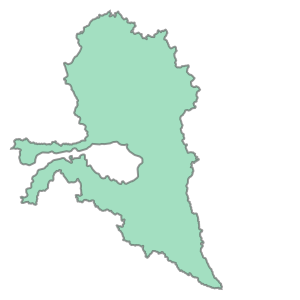

In [11]:
# Verificamos la geometría que hay que utilizar dentro
# del split para el área sobre la curva de nivel.
i = 22
j = 0

print(subc_c.shape)
shp.ops.split(Subcuenca.loc[0, "geometry"], subc_c.loc[i, "geometry"])[j]

In [12]:
# Área sobre las curvas de nivel.

# Geometrías a utilizar dentro del split
# para el área sobre las curvas de nivel.
j = [ [1, 2, 3], [1], [1], [1, 2, 3], [1, 2], [1],
      [1], [1, 2, 3, 4], [1], [1], [1], [1], [1],
      [0], [1], [1], [1], [1], [1], [1], [1], [1],
      [0], [1], [1], [1], [1], [1], [1], [0]  ]
m = []

# Iteramos para todas las isoyetas.
for i in range(subc_c.shape[0]):

    g = []
    # Curva de la isoyeta.
    l = subc_c.loc[i, "geometry"]

    # Unimos todas las geometrías del área sobre las curvas de nivel.
    for k in j[i]:
        g.append( shp.ops.split( Subcuenca.loc[0, "geometry"], l)[k] )

    # Agregamos la geometría.
    m.append( shp.geometry.MultiPolygon(g) )

# Agregamoslas geometrías creadas.
subc_c[f"{Subcuenca.loc[0, 'CVE_SUBCUE']}_POLY"] = m

# Calculamos el área de las área sobre las curvas de nivel
subc_c[f"{Subcuenca.loc[0, 'CVE_SUBCUE']}_AREA"] = subc_c.set_geometry(
    f"{Subcuenca.loc[0, 'CVE_SUBCUE']}_POLY").area

subc_c.head()

,Unnamed: 0,LENGTH,COV_ID,CONTOUR,geometry,RH01Bd,RH01Bd_POLY,RH01Bd_AREA
0,942,0.165202,2059,2401,"LINESTRING (635926.830 3430198.560, 635834.179...","MULTILINESTRING ((643984.178 3443302.022, 6439...",(POLYGON ((643291.5088121063 3444588.513461953...,2.102326e+06
1,1123,0.176539,2272,2001,"LINESTRING (636214.191 3437133.659, 635866.864...","LINESTRING (640601.561 3449103.005, 640529.986...",(POLYGON ((640601.5605243861 3449103.005611579...,8.993522e+06
2,672,0.051059,1517,2001,"LINESTRING (641005.774 3455230.503, 641213.508...","LINESTRING (639510.212 3455933.658, 639572.848...",(POLYGON ((639510.2127752864 3455933.658535537...,7.146698e+03
3,370,0.078376,811,1601,"LINESTRING (620084.167 3503023.652, 620272.509...","MULTILINESTRING ((620084.167 3503023.652, 6202...",(POLYGON ((618723.4429484344 3504072.855940994...,8.006153e+05
4,445,0.168852,966,1601,"LINESTRING (632276.684 3493299.622, 632298.824...","MULTILINESTRING ((632276.684 3493299.622, 6322...",(POLYGON ((632585.9405356761 3496200.489735003...,1.023380e+07


In [13]:
# Curva hipsométrica.

# Niveles dentro de la subcuenca.
Z = subc_c["CONTOUR"].unique()
P_A = [None] * Z.shape[0]

# Iteramos para cada nivel
for i in range( Z.shape[0] ):
    # Sumamos el área sobre cada nivel
    # y lo dividimos entre el área de la cuenca.
    P_A[i] = ( subc_c.loc[ subc_c["CONTOUR"] == Z[i],
        f"{Subcuenca.loc[0, 'CVE_SUBCUE']}_AREA" ].sum()
        / Subcuenca.loc[ 0, "AREA"] ) 

# Agreamos el punto de 100%.
Z = np.concatenate([Z, [0]]) 
P_A.append(1)

# Creamos la curva hipsométrica.
hipsometrica = pd.DataFrame([Z, P_A]).T
hipsometrica.columns = ["Z", "%A"]
hipsometrica = hipsometrica.set_index("%A")

hipsometrica

,Z
%A,
0.001135,2401.0
0.004859,2001.0
0.041562,1601.0
0.205613,1201.0
0.638536,801.0
0.771939,401.0
1.000000,0.0


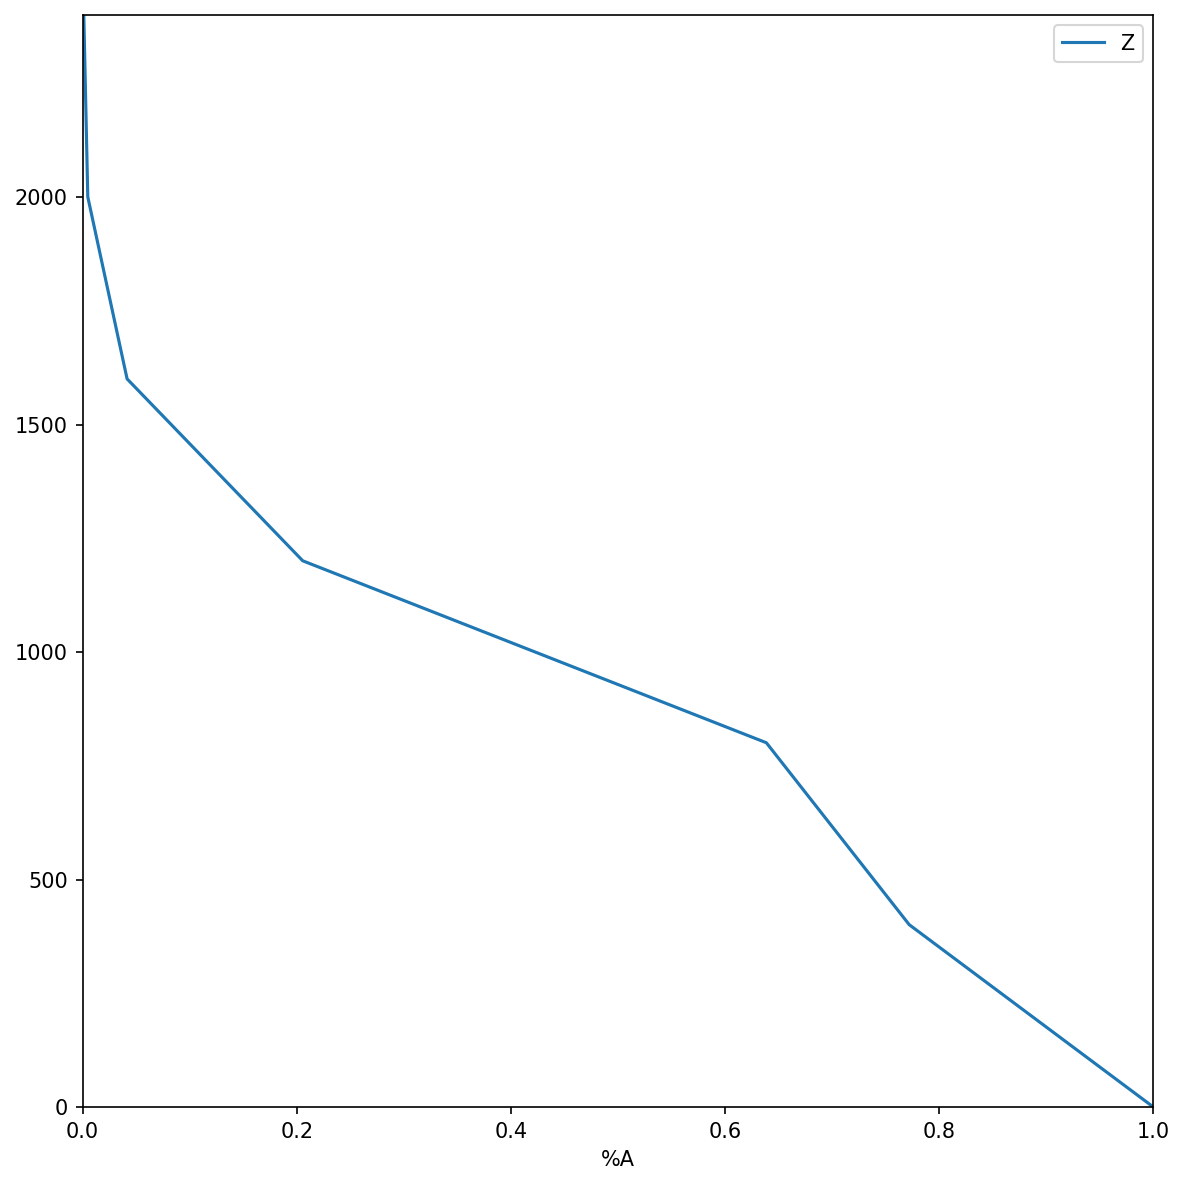

In [14]:
# Graficamos la curva hipsométrica.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 8)
fig.set_dpi(150) 

# Graficamos.
hipsometrica.plot( ax= ax )

# Estilo.
ax.set_xlim(0, 1)
ax.set_ylim(0, Z.max())

fig.tight_layout()
plt.show()